# Titanic Top 4% with ensemble modeling
## Yassine Ghouzam, PhD
### 13/07/2017
* 1 Introduction
* 2 Load and check data
 * 2.1 load data
 * 2.2 Outlier detection
 * 2.3 joining train and test set
 * 2.4 check for null and missing values
* 3 Feature analysis
 * 3.1 Numerical values
 * 3.2 Categorical values
* 4 Filling missing Values
 * 4.1 Age
* 5 Feature engineering
 * 5.1 Name/Title
 * 5.2 Family Size
 * 5.3 Cabin
 * 5.4 Ticket
* 6 Modeling
 * 6.1 Simple modeling
   - 6.1.1 Cross validate models
   - 6.1.2 Hyperparamater tunning for best models
   - 6.1.3 Plot learning curves
   - 6.1.4 Feature importance of the tree based classifiers
 * 6.2 Ensemble modeling
   - 6.2.1 Combining models
 * 6.3 Prediction
   - 6.3.1 Predict and Submit results
   
# 1. Introduction

먼저 몇 가지 feature 분석을 표시한 다음 feature engineering에 중점을 둘 것이다. 마지막 부분은 투표 절차를 사용하여 타이타닉호의 생존을 모델링하고 예측하는 것과 관련이 있다.

이 스크립트는 아래의 세 가지를 중점적으로 다룰 것이다.

* Feature analysis
* Feature engineering
* Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style = 'white', context = 'notebook', palette = 'deep')

pd.set_option('mode.chained_assignment',  None)

# 2. Load and check data

## 2.1 Load data

In [2]:
#데이터 불러오기

train = pd.read_csv("~/aiffel/kaggle_practice/titanic/train.csv")
test = pd.read_csv("~/aiffel/kaggle_practice/titanic/test.csv")
IDtest = test['PassengerId']

## 2.2 Outlier detection

In [3]:
# outlier detection

def detect_outliers(df, n, features):
    """
    feature의 데이터프레임을 사용하고 Tukey 메서드에 따라 n개 이상의 outlier를 
    포함하는 관측치에 대한 인덱스 리스트를 반환한다.
    Takes a dataframe df of features and returns a list of the indices
    correspoinding to the observations containing more than n outliers according
    to the Tukey method.
    """
    
    outlier_indices = []
    
    #iterate over features(columns)
    for col in features:
        #1st quartile(25%)
        Q1 = np.percentile(df[col], 25)
        #3rd quaritile(75%)
        Q3 = np.percentile(df[col], 75)
        #Interquartile range(IQR)
        IQR = Q3 - Q1
        
        #outlier step
        outlier_step = 1.5 * IQR
        
        #피쳐 컬럼에 대한 이상값 인덱스 리스트 지정
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        #컬럼에 발견된 이상치 인덱스를 이상치 인덱스 리스트에 추가
        outlier_indices.extend(outlier_list_col)
        
    #2개 이상의 이상값을 포함하는 관측값 선택
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

#Age, SibSp, parch 및 Fare에서 이상값 발견
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

outlier가 예측(특히 회귀 문제의 경우)에 극적인 영향을 미칠 수 있으므로 이를 조정할 수 있게끔 했다.

Tukey 방법(Tukey JW., 1977)을 사용하여 분포 값의 1분위와 3분위수(IQR) 사이에 구성된 사분위간 범위를 정의하는 outlier를 검출했다. outlier는 feature 값이 (IQR +- outlier 단계)외부에 있는 행이다.

숫자 값 특징(Age, SibSp, Sarch 및 Fare)에서 outlier를 탐지하기로 결정했다. 그리고 outlier를 최소 두 개의 초과된 숫자 값을 갖는 행으로 간주했다.

In [4]:
train.loc[Outliers_to_drop] #show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 outlier를 발견했다. 승객 28, 89, 342은 티켓 요금을 많이 지불했다.

그 외의 나머지 7명은 SibSP의 값이 매우 높다.

In [5]:
#outlier 삭제
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)

## 2.3 joining train and test set

In [6]:
#join train adn test datasets in order to obtain the same numver fo features
#during categorical conversion
#범주형 변환 중에 동일한 수의 feature를 얻을 수 있도록 train 및 test dataset 결합

train_len = len(train)
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)

## 2.4 check for null and missing values

In [7]:
#빈 데이터 NaN으로 채우기
dataset = dataset.fillna(np.nan)

#빈 데이터 몇 개인지 확인
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

age 및 cabin feature은 결측값이 많다.

survived 결측값은 합쳐 테스트 데이터 집합에 해당한다(survived 열은 test set에 존재하지 않으며 train과 test set을 합칠 때 NaN 값으로 대체되었다).

In [8]:
#infos

train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
#summarize data
#summarie and statistics

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis
## 3.1 Numerical values

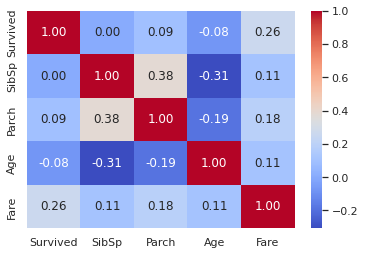

In [12]:
#숫자 값(SibSp Parch Age 및 Fare 값)과 survived 사이의 상관관계를 나타내는 히트맵
g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot=True, fmt = ".2f", cmap = "coolwarm")


Fare feature만 생존 확률과 유의한 상관 관계가 있는 것으로 보인다.

다른 feature들이 완전히 사용되지 않는다는 뜻은 아니다. 이러한 feature의 하위 모집단은 생존과 상관관계가 있을 수 있다. 이를 확인하기 위해서는 이러한 feature를 자세히 살펴볼 필요가 있다.

### SibSP

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


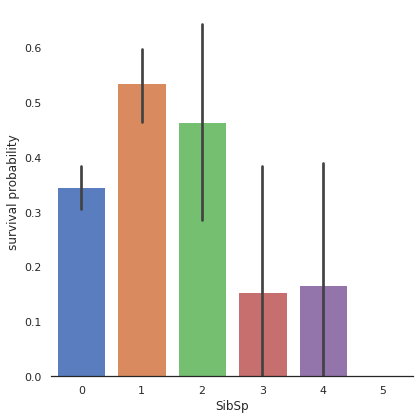

In [13]:
#SibSp feature와 Survived 비교

g = sns.factorplot(x = 'SibSp', y = 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')

#.despine : 플롯 전체에서 상단, 제일 오른쪽 선 지움
#left=True : 왼쪽 선도 지
g.despine(left = True)
g = g.set_ylabels('survival probability')

형제/자매가 많은 승객은 생존률이 적다.

1인 승객(0 SibSP) 또는 다른 2인 승객(SibSP 1 또는 2)이 생존할 가능성이 더 높다.

이러한 범주를 설명하는 새로운 feature를 생각해볼 수 있다(feature engineering 참조).

### Parch

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


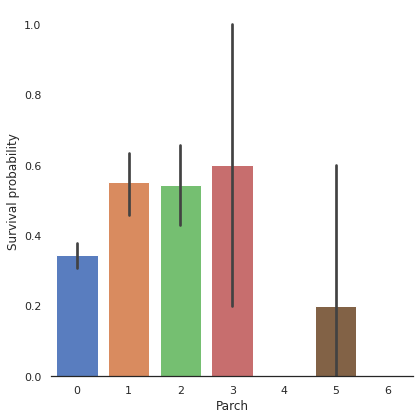

In [14]:
#Explore Parch feature vs Survived
g = sns.factorplot(x = 'Parch', y = 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival probability')

작은단위의 가족은 혼자 탑승한 승객과(Parch 0), 함께 탑승한 부모자식의 수가 3~4(Parch 3,4) 및 함께 탑승한 부모자식의 수가 큰 가족(Parch 5,6 )보다 생존 확률이 높다.

세 명의 부모/자녀가 있는 승객의 생존에 표준 편차가 크게 있으니 주의 해야한다.

### Age

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


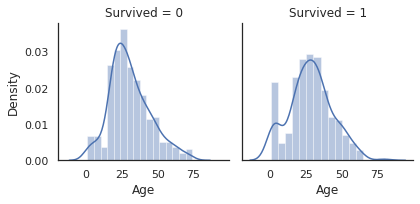

In [15]:
#Explore Age vs Survived
'''
FacetGrid[그리는 방법]
1. FacetGrid에 데이터프레임과 구분할 row, col, hue 등을 전달해 객체 생성
2. 객체(facet)의 map 메서드에 그릴 그래프의 종류와 종류에 맞는 컬럼 전달
예시 - distplot의 경우 하나의 컬럼 // scatter의 경우 두개의 컬럼
'''
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

age 분포는 꼬리 분포로 보이며 가우스 분포일 수도 있다.

생존한 모집단과 생존하지 못한 모집단에서 연령 분포가 동일하지 않다는 것을 알 수 있다. 젊은 승객에 해당하는 봉우리가 있는데, 이들은 살아남은 것을 뜻한다. 또한 60-80세 사이의 승객들이 덜 살아남았다는 것을 알 수 있다.

그래서, "나이"가 "생존"과 상관관계가 없다고 해도, 생존할 기회가 더 많거나 더 적은 승객들의 나이 범주가 있다는 것을 알 수 있다.

매우 어린 승객들은 생존할 수 있는 기회가 더 많아 보인다.

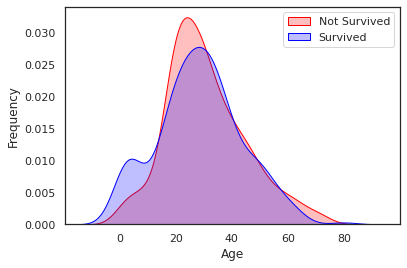

In [16]:
#Explore Age distribution

#커널 밀도 추정 그래프
#히스토그램 같은 분포를 부드럽게 곡선화 시켜서 그려줌
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color = 'Blue', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

두 밀도 그래프를 겹칠 때, 아기들과 매우 어린 아이들(0에서 5 사이)의 경우, 생존 그래프가 볼록하게 솟은 것을 알 수 있다.

### Fare

In [17]:
dataset['Fare'].isnull().sum()

1

In [18]:
#Fill Fare missing values with the median value
#.median(): 중앙값
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

요금 feature에는 하나의 결측치가 있기 때문에, 이 결측치를 나중에 예측할 때 많은 영향을 끼치지 않는 값으로 채울 것이다.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


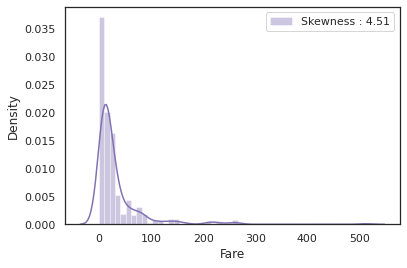

In [19]:
#Explore Fare distrbution
#label : 범주 지정
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))

#best: 두면 제일 좋을 것 같은 위치에 범주 놓기
g = g.legend(loc = 'best')

요금 분포가 매우 왜곡되어 있다. 이렇게 하면 크기가 조정되더라도 모델에서 지나치게 높은 값이 나올 수 있습니다.

이 경우에는 로그 함수로 변환하여 이 왜곡을 줄이는 것이 좋다.

In [20]:
#Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


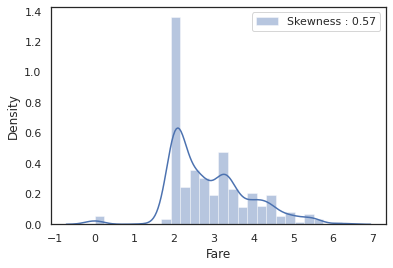

In [21]:
g = sns.distplot(dataset['Fare'], color ='b', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

로그 변환덕에 치우쳐있던 그래프가 조정되었다.

## 3.2 Categorical values
### Sex

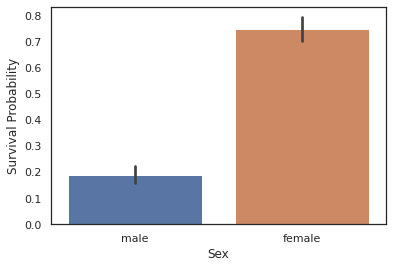

In [22]:
g = sns.barplot( x = 'Sex', y = 'Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [23]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남성이 여성보다 생존 가능성이 적다는 것은 명백하다.

그럼 Sex는 생존을 예측하는 데 중요한 역할을 할 수도 있겠다.

타이타닉 영화(1997년)를 본 사람이라면 대피하는 동안 우리 모두는 이 문장을 기억할 것이다: "여성과 아이들이 먼저".

### Pclass

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


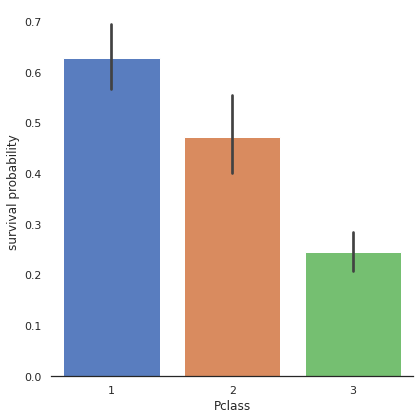

In [24]:
#Explore Pclass vs Survived
g = sns.factorplot(x = 'Pclass', y= 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


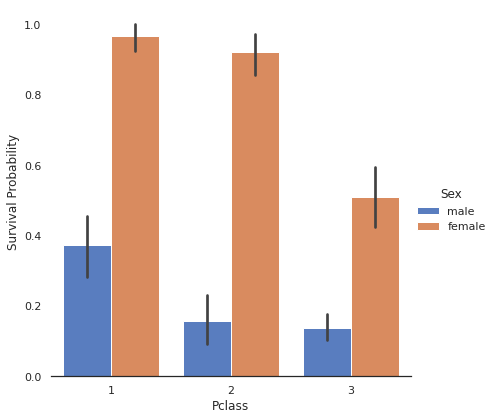

In [25]:
#Explore Pclass vs Survived by Sex
g = sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, size = 6, kind= 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability')

세 클래스에서 승객 생존율이 같지 않다. 일등석 승객은 이등석, 삼등석 승객보다 생존 가능성이 높다.

이러한 경향은 우리가 남성 승객이나 여성 승객 모두를 볼 때 여전하다.

### Embarked

In [26]:
dataset['Embarked'].isnull().sum()

2

In [27]:
#Fill embarked nan values of dataset set with 'S' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

결측값이 두 개 있는데, 승객이 가장 많이 사용한 탑승구로 채울 것이다.

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


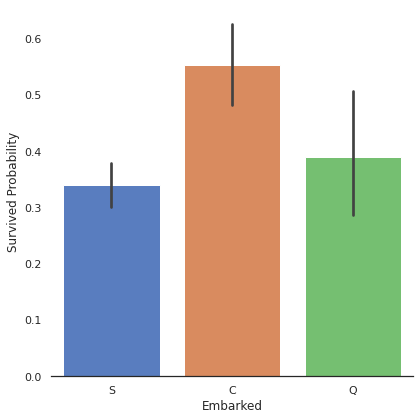

In [28]:
#Explore Embarked vs Survived
g = sns.factorplot(x = 'Embarked', y = 'Survived', data = train, size = 6, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survived Probability')

(C)에서 탄 승객의 생존률이 더 크다.

(Q), (S)보다 (C)탑승구를 이용한 사람들의 일등석 승객 비율이 더 높다는 것이라는 생각을 해볼 수 있다..

Pclass 분포 vs Boarded를 살펴보자.

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


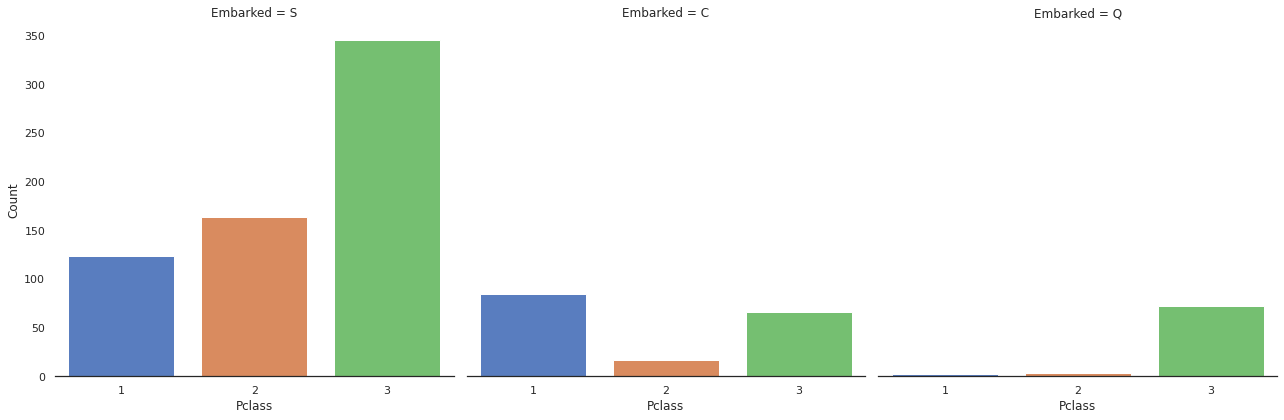

In [29]:
#Explore Pclass vs Embarked
g = sns.factorplot('Pclass', col = 'Embarked', data= train, size = 6, kind = 'count', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Count')

실제로 (S)와 (Q)에서 오는 승객은 3등급이 가장 많은 반면 (C) 승객은 생존율이 가장 높은 1등급이 대부분이다.

대피하는 동안 일등석 승객들이 그들의 영향으로 인해 우선시 되었을 것이다.

# 4. Filling missing Values
## 4.1 Age

Age 열에는 전체 데이터 집합의 결측값 256개가 포함되어 있다.

생존 기회가 더 많은 하위 집단(예: 어린이)이 존재하기 때문에 age feature를 유지하고 결측값을 귀속시키는 것이 바람직하다.

이 문제를 해결하기 위해 에이지(Sex, Parch, Pclass, SibSP)와 가장 상관관계가 있는 특징을 살펴보았다.

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt

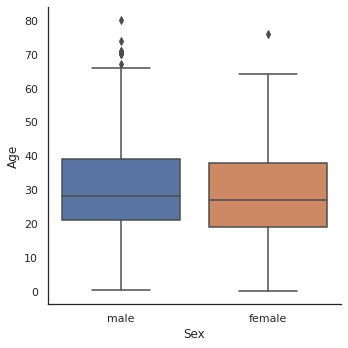

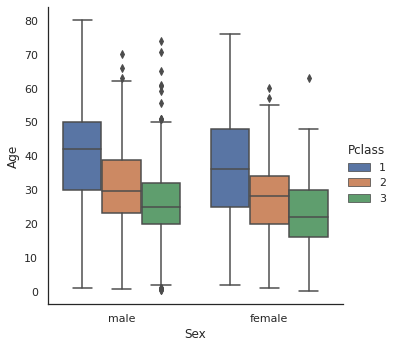

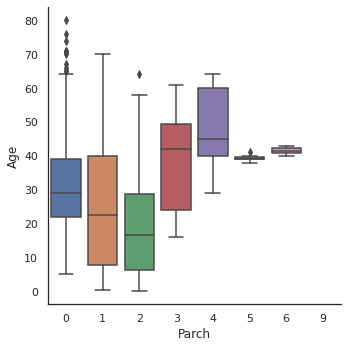

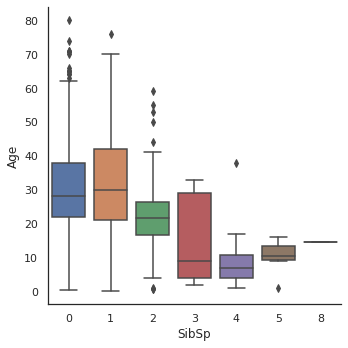

In [30]:
#Explore Age vs Sex, Parch, Pclass and SibSp
g = sns.factorplot(y = 'Age', x = 'Sex', data = dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'Sex', hue = 'Pclass', data=dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'Parch', data = dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'SibSp', data = dataset, kind = 'box')

남성과 여성의 하위 집단에서 연령 분포는 동일한 것으로 보여서 성별은 나이를 예측하는 데 도움이 되지 않는다.

그러나 1등석 승객은 2등석 승객보다 나이가 많고, 2등석 승객은 3등석 승객보다 나이가 많다.

(??)게다가, 승객이 부모/자식을 더 많이 가질수록 나이가 더 많고 승객은 더 어린 형제/자매를 가지고 있다.

In [31]:
#convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})

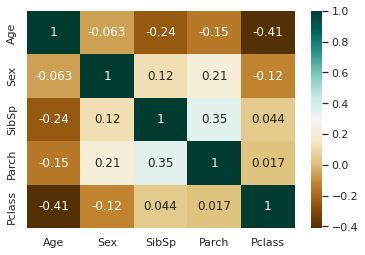

In [32]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap = 'BrBG', annot = True)

상관 관계 맵은 Parch를 제외한 factorplots 관측치를 확인한다. 나이는 성별과 상관관계가 없지만 Pclass, Parch, SibSp와 음의 상관관계가 있다.

Parch의 함수 연령 그림에서 나이는 부모/자녀의 수에 따라 증가합니다. 그러나 일반적인 상관관계는 음수이다.

나이의 결측값을 채워넣기 위해 SibSP, Parch, Pclass를 사용하기로 했다.

Pclass, Parch 및 SibSp에 따라 유사한 행의 중위수로 Age를 채우는 것이다.

In [33]:
#Age 결측치 채우기
#Pclass, Parch 및 SibSp에 따라 비슷한 행의 중앙값으로 Age 채우기
#Index of NaN age rows

index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    #isnan():어떤 값이 NaN인지 판별
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


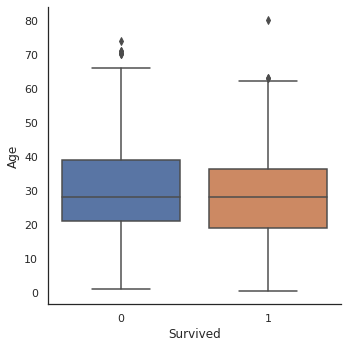

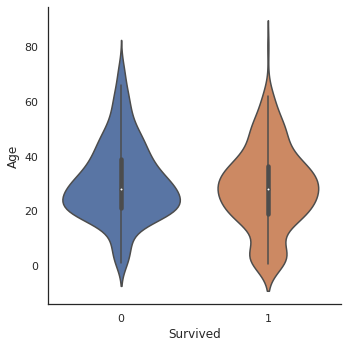

In [34]:
g = sns.factorplot(x = 'Survived', y = 'Age', data = train, kind = 'box')
g = sns.factorplot(x = 'Survived', y = 'Age', data = train, kind = 'violin')

생존한 하위 집단과 생존하지 않은 하위 집단에서 연령의 중앙값 사이에는 차이가 없다.

그러나 생존한 승객의 바이올린 플롯에서 여전히 아주 어린 승객의 생존율이 더 높다는 것을 알 수 있다.

# 5. Feature engineering
## 5.1 Name/Title

In [35]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name feature에는 승객의 직위 정보가 포함된다.

대피하는 동안 고유한 직함을 가진 일부 승객이 선호될 수 있으므로 모델에 추가하는 것이 좋을 것이다.

In [36]:
# get title from name
#strip() 공백제거
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

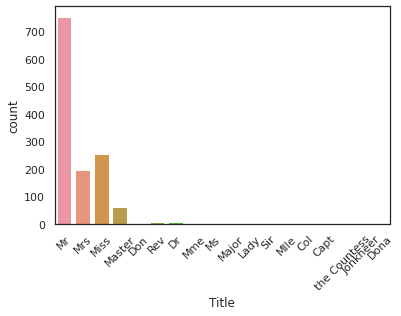

In [37]:
g = sns.countplot(x = 'Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

17개의 타이틀이 있다. 

In [38]:
#Convert to categorical values Title
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({"Master": 0, "Miss": 1, "Ms" : 1 , "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3})
dataset['Title'] = dataset['Title'].astype(int)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


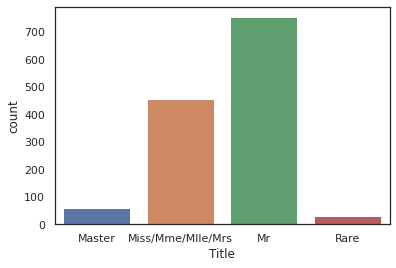

In [39]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Mme/Mlle/Mrs', 'Mr', 'Rare'])

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


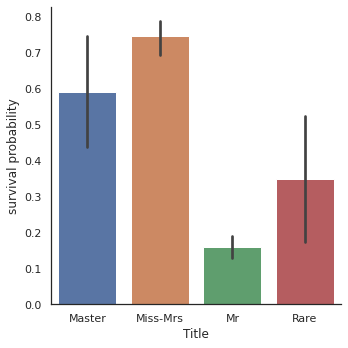

In [40]:
g = sns.factorplot(x = 'Title', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

"여성과 아이 먼저"

희귀 타이틀을 가진 승객이 생존할 확률이 더 높다는 점은 흥미롭다.

In [41]:
#drop Name variable
#axis = 1 : 열 삭제
dataset.drop(labels = ['Name'], axis = 1, inplace = True)

### 5.2 Family size

대가족의 경우 대피하는 동안 자신의 가족들을 챙겨서 대피하여 대피 시 더 많은 어려움을 겪었을 것이라고 생각할 수 있다. 

그래서 SibSp , Parch 및 1(승객 포함)의 합계인 "Fize"(패밀리 크기) 기능을 만들기로 결정했다.

In [42]:
#create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


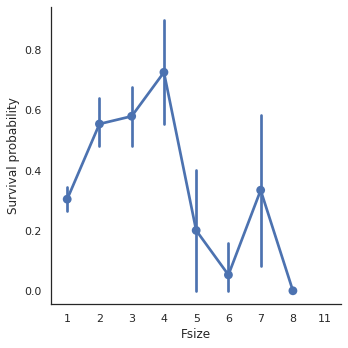

In [43]:
g = sns.factorplot(x = 'Fsize', y = 'Survived', data = dataset)
g = g.set_ylabels('Survival probability')

가족 규모가 중요한 역할을 하는 것으로 보이며, 대가족의 경우 생존 확률이 가장 낮다.

또한 4가지 범주의 가족 규모를 만들기로 결정했다.

In [44]:
#create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt

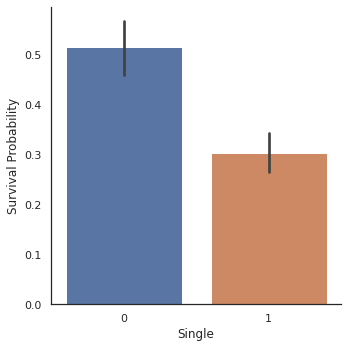

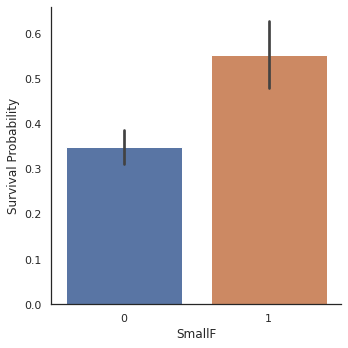

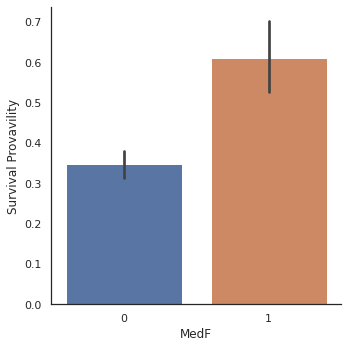

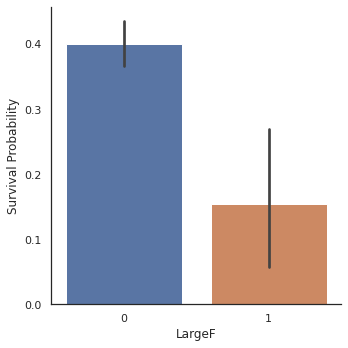

In [45]:
g = sns.factorplot(x = 'Single', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x = 'SmallF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x = 'MedF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Provavility')

g = sns.factorplot(x = 'LargeF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')

가족 규모 범주의 팩터플롯은 중소 가족이 1인 승객 및 대가족보다 생존률이 더 크다는 것을 보여준다.

In [46]:
#convert to indicator values Title and Embarked
#.get_dummies: 지정 컬럼의 데이터 값으로 새로이 열만들어서 분리하기
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em')

In [47]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


표를 보면 22개의 feature가 있는 것을 알 수 있다.

## 5.3 Cabin

In [48]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [50]:
dataset['Cabin'].isnull().sum()

1007

Cabin featuresms 292개의 value와 1007개의 결측치를 가지고 있다.

객실이 없는 승객은 객실 번호 대신 누락된 값이 표시된다고 가정했다.

In [51]:
#notnull() 메소드는 관측치가 결측이면 False, 결측이 아니면 True를 반환
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [52]:
#replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

객실의 첫 글자는 갑판을 나타내며 타이타닉 안에서 승객이 있을법한 위치를 나타내기 때문에 이 정보만 유지하기로 결정했다.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


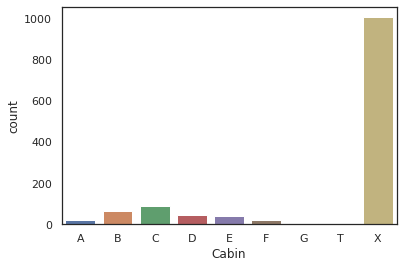

In [53]:
g = sns.countplot(dataset['Cabin'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


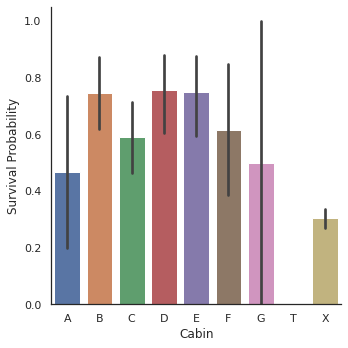

In [54]:
g = sns.factorplot(y = 'Survived', x = 'Cabin', data = dataset, kind = 'bar', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Probability')

객실이 있는 승객의 수가 적기 때문에 생존률은 중요한 표준 편차를 가지며, 다른 갑판에 있는 승객의 생존 확률을 구별할 수 없다.

그러나 캐빈이 있는 승객은 일반적으로 (X)가 없는 승객보다 생존할 확률이 더 높다는 것을 알 수 있다.

캐빈 B, C, D, E 및 F의 경우 특히 그렇다.

In [55]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

## 5.4 Ticket

In [56]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

동일한 접두사를 공유하는 티켓은 함께 배치된 캐빈에 대해 예약될 수 있음을 의미할 수 있다. 따라서 선박 내 캐빈의 실제 배치로 이어질 수 있습니다.

접두어가 같은 티켓은 이용한 클래스와 생존률이 비슷할 수 있습니다.

그래서 티켓 feature를 티켓 접두사로 바꾸기로 결정했습니다. 더 많은 정보를 얻을 수 있을 것다.

In [57]:
# Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
    # isdigit() 함수는 문자열이 숫자로 구성되어 있는지 판별해주는 함수
    if not i.isdigit():
        Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append('X')
        
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [58]:
#prefix: 생성할 dummy variable의 column 이름 앞에 붙을 prefix를 지정함
# 범주형 column에 따라 리스트나 딕셔너리를 통해 컬럼별 prefix 따로 지정 가능
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')

In [59]:
#Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')

In [60]:
#Drop useless variables
#inplace = True: 기존 데이터 프레임에 변경된 설정으로 덮어쓰겠다. = drop을 제대로 실행하겠다
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [61]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6.Modeling

In [62]:
# Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis = 1, inplace = True)

In [63]:
#Separate train features and label

train["Survived"] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels = ['Survived'], axis = 1)

## 6.1 Simple modeling
### 6.1.1 Cross validate models

통상적으로 많이 사용하는 10개의 분류기를 비교하고, 계층화된 kfold 교차 검증 절차를 통해 각 분류기의 평균 정확도를 평가했습니다.

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [64]:
#Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits = 10)

In [65]:
#Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

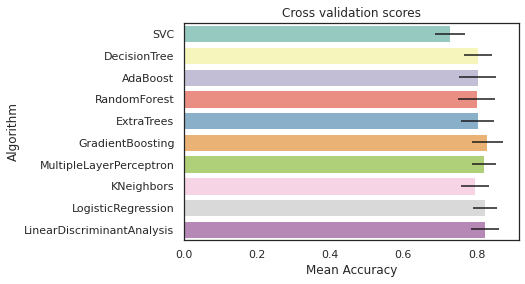

In [66]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv = kfold, n_jobs = 4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
        
cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 'Algorithm': ['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighbors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

    

앙상블 모델링을 위해 SVC, AdaBoost, RandomForest, ExtraTrees 및 GradientBoosting 분류기를 선택하기로 결정했다.

### 6.1.2 Hyperparameter tunning for best models

AdaBoost, ExtraTrees, RandomForest, GradientBoosting 및 SVC 분류기에 대한 그리드 검색 최적화를 수행했다.

cpu가 4개이므로 "n_jobs" 매개변수를 4로 설정했다. 계산 시간이 확실히 줄어든다.

이 단계는 시간이 오래 걸릴 수 있다.

In [67]:
##Meta modeling with Adaboost, RF, ExtraTrees and GradientBoosting

#Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state = 7)

ada_param_grid = {'base_estimator__criterion' : ['gini', 'entropy'],
                  'base_estimator__splitter': ['best'],
                  'algorithm': ['SAMME', 'SAMME.R'],
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5],
                  'n_estimators': [1, 2]}
gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)
                                                 
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_                                                 
                                                 

Fitting 10 folds for each of 56 candidates, totalling 560 fits


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

In [68]:
gsadaDTC.best_score_

0.8275536261491316

In [69]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


#Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv = kfold, scoring = "accuracy", n_jobs = 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342951991828397

In [70]:
#RFC Parameters tunning 
RFC = RandomForestClassifier()

#Search grid for optimal parameters
rf_param_grid = {'max_depth': [None],
              'max_features': [1, 3, 10],
              'min_samples_split': [2, 3, 10],
              'min_samples_leaf': [1, 3, 10],
              'bootstrap': [False],
              'n_estimators': [100, 300],
              'criterion': ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

#Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320224719101125

In [71]:
#Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ['deviance'],
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 8],
                'min_samples_leaf': [100, 150],
                'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

#best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8286133810010214

In [72]:
#SVC classifier
SVMC = SVC(probability = True)
svc_param_grid = {'kernel': ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv=kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsSVMC .fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

#best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

6.1.3 Plot learning curves

Learning curves는 훈련 세트에 대한 과적합 효과와 정확도에 대한 훈련 크기의 영향을 확인하는 좋은 방법이다.

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid featu

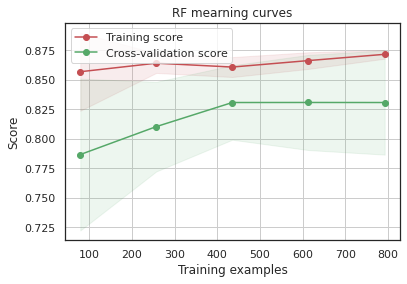

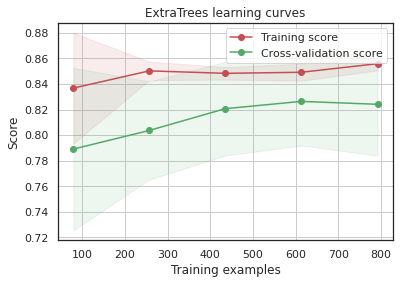

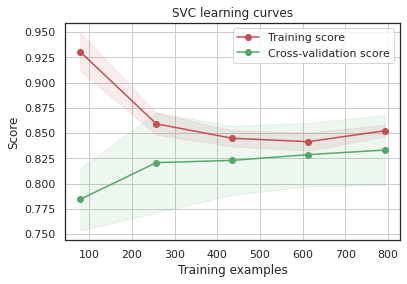

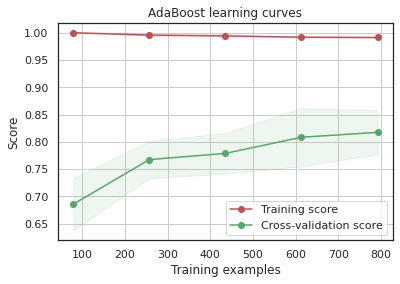

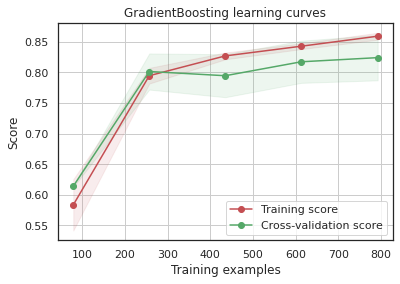

In [73]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):
    '''generate a simple plot of the test and training learning curve'''
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis =1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1,
                    color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Cross-validation score')
    plt.legend(loc='best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RF mearning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsExtC. best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv = kfold)

GradientBoosting 및 Adaboost 분류기는 훈련 세트를 과적합하는 경향이 있다. 증가하는 교차 검증 곡선에 따르면 GradientBoosting과 Adaboost는 더 많은 훈련 예제에서 더 나은 성능을 보일 수 있다.

SVC 및 ExtraTrees 분류기는 훈련 및 교차 검증 곡선이 서로 가깝기 때문에 예측을 더 잘 일반화하는 것 같다.

### 6.1.4 Feature importance of tree based classifiers

승객 생존 예측을 위한 가장 유익한 feature를 보기 위해 4개의 트리 기반 분류기에 대한 feature 중요도를 표시했다.

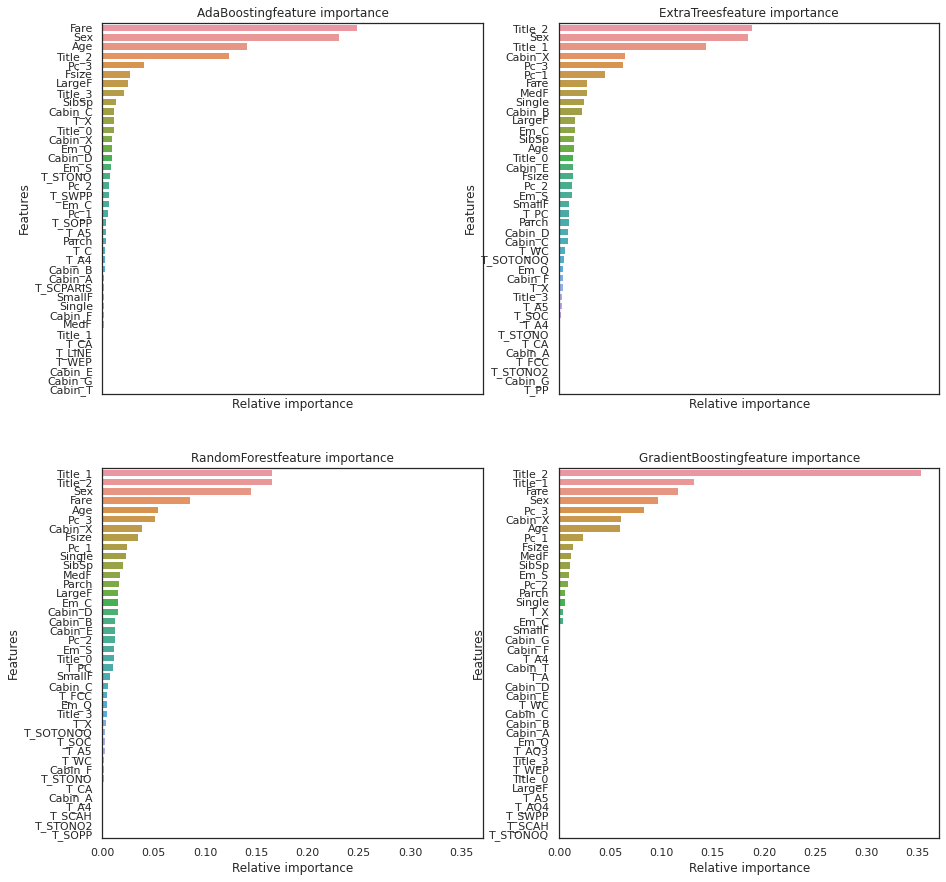

In [74]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = 'all', figsize = (15, 15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y = X_train.columns[indices][:40], 
                        x = classifier.feature_importances_[indices][:40], 
                        orient= 'h', 
                        ax = axes[row][col])
        g.set_xlabel('Relative importance', fontsize = 12)
        g.set_ylabel('Features', fontsize = 12)
        g.set_title(name + 'feature importance')
        nclassifier += 1

4가지 트리 기반 분류기(Adaboost, ExtraTrees, RandomForest 및 GradientBoosting)에 대한 기능 중요도를 표시한다.

4개의 분류기는 상대적 중요도에 따라 서로 다른 상위 feature을 가진다. 이는 그들의 예측이 동일한 feature을 기반으로 하지 않는다는 것을 의미한다. 

그럼에도 불구하고 'Fare', 'Title_2', 'Age' 및 'Sex'와 같이 분류에 대한 몇 가지 공통적인 중요한 feature을 공유한다.

Mrs/Mlle/Mme/Miss/Ms 카테고리를 나타내는 Title_2는 Sex와 높은 상관관계를 보인다.

위의 결과로 다음과 같이 말할 수 있다.

* Pc_1, Pc_2, Pc_3 및 Fare는 승객의 일반적인 사회적 지위를 나타낸다.
* 성별 및 Title_2(Mrs/Mlle/Mme/Miss/Ms) 및 Title_3(Mr)은 성별을 나타낸다.
* Age 및 Title_1(마스터)은 승객의 나이를 나타낸다.
* Fsize, LargeF, MedF, Single은 승객 가족의 크기를 나타낸다.

이 4가지 분류기의 특징 중요도에 따르면, 생존 예측은 배의 위치보다 승객의 연령, 성별, 가족 규모 및 사회적 지위와 더 관련이 있는 것으로 보인다.

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


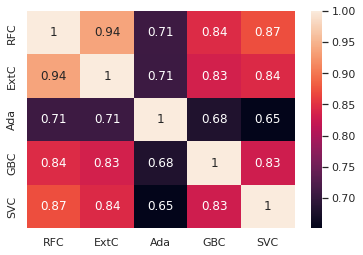

In [75]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name = 'RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name = 'ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name = 'SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name = 'Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name = 'GBC')

#Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC, 
                              test_Survived_ExtC, 
                              test_Survived_AdaC, 
                              test_Survived_GBC, 
                              test_Survived_SVMC], 
                             axis = 1)
g = sns.heatmap(ensemble_results.corr(), annot=True)

예측은 Adaboost가 다른 분류기와 비교할 때를 제외하고 5개의 분류기에 대해 매우 유사한 것으로 보인다.

5개의 분류기는 거의 동일한 예측을 제공하지만 몇 가지 차이점이 있다. 5개의 분류기 예측 간의 이러한 차이는 앙상블 투표를 고려하기에 충분하다.

## 6.2 Ensemble modeling
### 6.2.1 Combining models

저는 5개의 분류기에서 나오는 예측을 결합하기 위해 투표 분류기를 선택했다.

각 투표의 확률을 고려하기 위해 "soft" 인수를 투표 매개변수에 전달하는 것을 선호했다.

In [76]:
votingC = VotingClassifier(estimators = [('rfc', RFC_best), 
                                         ('extc', ExtC_best), 
                                        ('svc', SVMC_best), 
                                        ('adac', ada_best),
                                        ('gbc', GBC_best)],
                                        voting ='soft',
                                        n_jobs = 4)
votingC = votingC.fit(X_train, Y_train)

## 6.3 Prediction
### 6.3.1 Predict and Submit results

In [77]:
test_Survived = pd.Series(votingC.predict(test), name = 'Survived')
results = pd.concat([IDtest, test_Survived], axis = 1)
results.to_csv('ensemble_python_voting.csv', index = False)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
